In [1]:
%load_ext autoreload

In [2]:
import sys
import os
import time
import torch
import pickle
import parkinson

import numpy as np
import pandas as pd
import networkx as nx

import torch
import torch.nn.functional as F

from torch import nn
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

In [3]:
print(os.listdir('../'))
sys.path.append('../')

['README.md', 'pyproject.toml', 'outputs', 'parkinson', 'Makefile', 'poetry.toml', 'data', 'requirements.txt', 'weights', '.git', 'notebooks', '.venv', '.gitignore', 'poetry.lock']


In [4]:
RDN = 50
N_CLASSES = 3
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
DECAY = 0.000001
CORR_METHOD = "sliding_window"  # método de matriz de correlação: sliding_window, pearson...(no graph.py)
SAVE_PATH = '../outputs/1_corr_matrix_3classes'

# Modelo Correlation Matrix

## Processamento dos dados

In [5]:
# lendo os arquivos de dados
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Geração da matriz de correlação.
parkinson_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(parkinson_atlas_data)
control_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(control_atlas_data)
prodomal_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(prodomal_atlas_data)

# Concatenando grupo controle e grupo de Parkinson
# e filtrando os dados para remover entradas com NaN ou infinitos
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

# Criando DataLoaders
train_loader_cm = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False)
test_loader_cm = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

Started file reading...


100%|██████████| 188/188 [00:04<00:00, 43.57it/s]


File reading completed.


## Treinamento

In [6]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = parkinson.NetworkModels.customMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=N_CLASSES)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model1.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(
    model=model1, 
    train_loader=train_loader_cm, 
    val_loader=None, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR,
    path="../weights/5.1_final/corr_matrix"
)

metrics = parkinson.utils.train.evaluate(model1, test_loader_cm, device, path="../weights/5.1_final/corr_matrix")

train-loss: 0.2160  train-acc: 0.9938: 100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


CPU times: user 4.66 s, sys: 29.4 s, total: 34 s
Wall time: 44.7 s


 Acurácia     F1  Precisão   Recall
 0.695122 0.6768  0.677137 0.695122


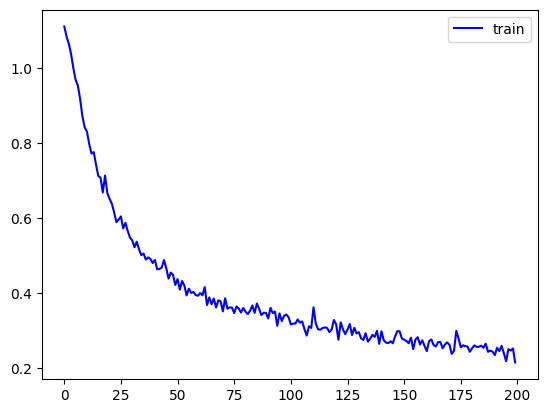

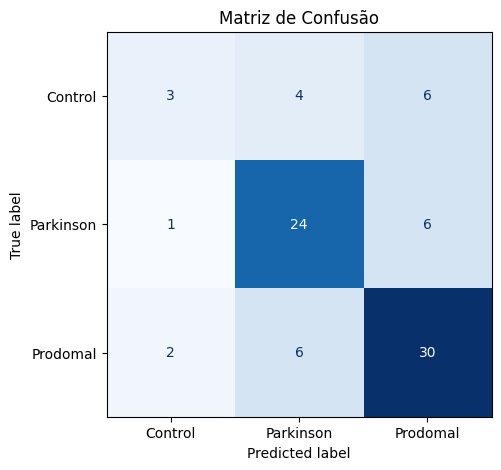

In [7]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'], None)
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson', 'Prodomal'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/loss_curve_{CORR_METHOD}.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix_{CORR_METHOD}.png", bbox_inches='tight')

# Modelo Time Series

## Processamento dos dados

In [8]:
# Lendo os dados dos arquivos.
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# Selecionando o atlas (estratégia de divisão cerebral: Shen_268 ou atlas ou AAL3).
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Transformando os dados selecionados em séries temporais (shape = [n_pacientes, n_canais, n_observações]).
control_ts_data = parkinson.utils.data.df_to_timeseries(control_atlas_data)
parkinson_ts_data = parkinson.utils.data.df_to_timeseries(parkinson_atlas_data)
prodomal_ts_data = parkinson.utils.data.df_to_timeseries(prodomal_atlas_data)

# Misturando pacientes Controle/Parkinson e trocando valores NaN por zero.
X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data, prodomal_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

# Criando DataLoader
train_loader_ts = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False)
test_loader_ts = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

Started file reading...


100%|██████████| 188/188 [00:03<00:00, 48.82it/s]


File reading completed.


## Treinamento

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = parkinson.NetworkModels.customFCN(X_train.shape[1], N_CLASSES)

model2.train()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

out = parkinson.utils.train.train(model2, train_loader_ts, None, device, N_EPOCHS, PATIENCE, LR, "../weights/5.1_final/time_series", DECAY)

metrics = parkinson.utils.train.evaluate(model2, test_loader_ts, device, "../weights/5.1_final/time_series")

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
train-loss: 0.1096  train-acc: 0.9908: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s]


 Acurácia       F1  Precisão  Recall
  0.47561 0.428438  0.399729 0.47561


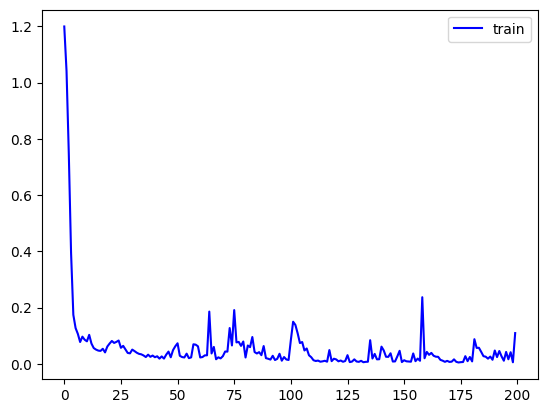

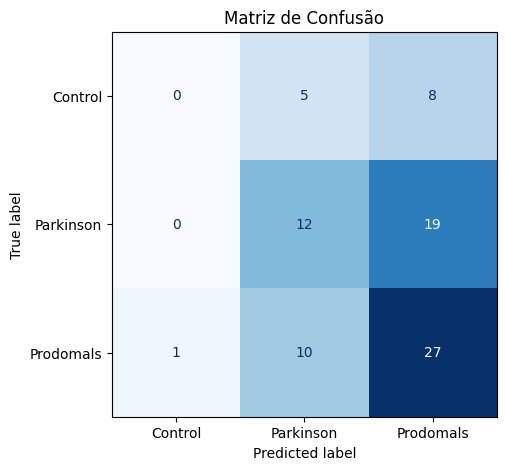

In [10]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'], None)
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix.png", bbox_inches='tight')

# Multimodal

In [11]:
def get_model_logits(model, dataloader, device, path_weights):
    model.load_state_dict(torch.load(path_weights, map_location=device))
    model.eval()
    model.to(device)

    all_logits = []
    with torch.no_grad():
        for x in dataloader:
            if isinstance(x, (list, tuple)):
                x = x[0]
            x = x.to(device)
            out = model(x)  # logits direto, sem softmax
            all_logits.append(out.cpu())

    return torch.cat(all_logits, dim=0).numpy()  # shape: (N amost_

In [15]:
logits1_train = get_model_logits(model1, train_loader_cm, device, "../weights/5.1_final/corr_matrix/best_model.pth")
logits2_train = get_model_logits(model2, train_loader_ts, device, "../weights/5.1_final/time_series/best_model.pth")
X_train = np.concatenate([logits1_train, logits2_train], axis=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    objective='multi:softprob',
    num_class=N_CLASSES,  # número de classes do seu problema
    eval_metric='mlogloss'
)
sample_weights = compute_sample_weight('balanced', y_train)
xgb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:44:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=3, ...)

In [16]:
logits1_test = get_model_logits(model1, test_loader_cm, device, "../weights/5.1_final/corr_matrix/best_model.pth")
logits2_test = get_model_logits(model2, test_loader_ts, device, "../weights/5.1_final/time_series/best_model.pth")
X_test = np.concatenate([logits1_test, logits2_test], axis=1)
X_test_scaled = scaler.transform(X_test)

preds = xgb.predict(X_test_scaled)
metrics = {
        'preds': preds,
        'labels': y_test,
        'acc': accuracy_score(y_test, preds),
        'f1':  f1_score(y_test, preds, average='weighted'),
        'precision': precision_score(y_test, preds, average='weighted'),
        'recall':  recall_score(y_test, preds, average='weighted')
    }

 Acurácia       F1  Precisão   Recall
 0.378049 0.352855  0.373577 0.378049


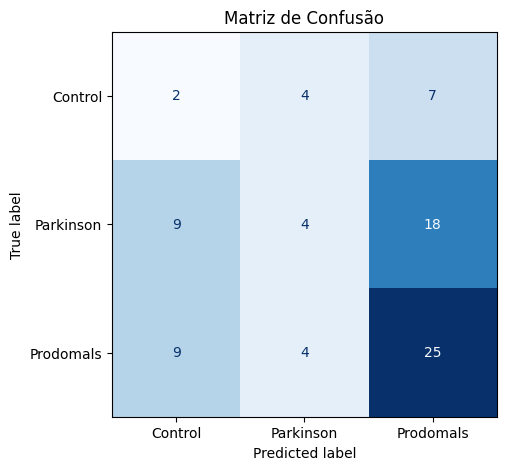

In [17]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_cf = parkinson.utils.results.plot_confusion_matrix(preds, y_test, class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()